In [1]:
#import libraries
import numpy as np
from ase.io import read, write
from ase import Atoms
import torch
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
os.makedirs('img_res', exist_ok=True) #creates a folder to store the loss graphs
os.makedirs('test_res', exist_ok=True) #creates a folder to store the files of the testing of the model
import functions as f #import functions used to plot

In [16]:
#I found a warning regarding the key names for energy and forces, the label changes from 'energy' to 'REF_energy'
input_file = "251030_training_data_lt_0eV.xyz"
output_file = "251030_training_data_lt_0eV_fixed.xyz"

with open(input_file, "r") as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    # Fix energy key in header lines
    if "energy=" in line:
        line = line.replace("energy=", "REF_energy=")
    # Fix forces key in Properties line
    if "Properties=" in line and "forces:R:3" in line:
        line = line.replace("forces:R:3", "REF_forces:R:3")
    new_lines.append(line)

# Write the fixed file
with open(output_file, "w") as f:
    f.writelines(new_lines)

In [2]:
read_data = read('251030_training_data_lt_0eV_fixed.xyz', index=':')
db_data = [(a.info['REF_energy']) for a in read_data]
df = pd.DataFrame(db_data, columns=['REF_energy'])
df

,REF_energy
0,-3.283081
1,-0.810493
2,-0.275595
3,-44.585548
4,-48.184644
...,...
625,-106.479300
626,-102.204540
627,-101.649356
628,-98.841753


In [59]:
#this part is to change the labels of the energies in order to add weigths during training
input = '251030_training_data_lt_0eV_fixed.xyz'
output = '251030_training_data_lt_0eV_weight.xyz'

high_e = df['REF_energy'].quantile(0.99)
low_e = df['REF_energy'].quantile(0.01)

with open(input, 'r') as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    if 'REF_energy=' in line:
        try:
            energy = float(line.split('REF_energy=')[1].split()[0])
        except (IndexError, ValueError):
            energy = None

        if 'config_type=IsolatedAtom' not in line and energy is not None:
            if energy > high_e:
                line = line.replace(line.split('config_type=')[1].split()[0], 'highE')
            elif energy < low_e:
                line = line.replace(line.split('config_type=')[1].split()[0], 'lowE')
    new_lines.append(line)

with open(output, 'w') as f:
    f.writelines(new_lines)

In [33]:
df['REF_energy'].quantile(0.01)

-253.8200631984

In [25]:
df['REF_energy'].quantile(0.99)

-7.769200702899989

In [60]:
#importing the full data (this is in case I have like the whole data in one file)
#db = read('251030_training_data_lt_0eV_fixed.xyz', ':')
db = read('251030_training_data_lt_0eV_weight.xyz', ':')

In [61]:
#splitting the data into the training and test sets
write('train_01.xyz', db[:520])
write('test_01.xyz', db[520:])

In [3]:
#setting the model name based on model number and epochs
device = 'cpu'
''' model_num:
    1 -> this indicates the model using 250 training data
    2 -> this indicates the model using 520 training data which is 80% of the data set
    3,4 -> this indicates the model using different values of learning rate 0.005, 0.0001 '''
model_id = 'scaleshift_lr0.0001_weighted01'
#model_id = 'scaleshift_lr0.0001'
#model_id = 'mace_lr0.0001'
#model_num = 4
''' num_epochs:
    sets the number of epochs used for running the trainig'''
num_epoch = 25
''' batch_size:
    sets the batch size for training'''
batch_size = 25
''' model_name:
    generates the name of the model based on the number of epochs and the model number using the 'model_num' variable '''
model_name = f'model_{model_id}_{num_epoch}epochs_{batch_size}batch'
model_name

'model_scaleshift_lr0.0001_weighted01_25epochs_25batch'

In [4]:
#this writes the yml file
config = {
    "model": "ScaleShiftMACE",
    #"model": "MACE",
    "num_channels": 32,
    "max_L": 0,
    "r_max": 4.0,
    "name": model_name,
    "train_file": f"train_01.xyz",
    "valid_fraction": 0.01,
    "test_file": f"test_01.xyz",
    "energy_key": "REF_energy",
    "forces_key": "REF_forces",
    "batch_size": batch_size,
    "max_num_epochs": num_epoch,
    "optimizer" : "adam",
    "lr":0.0001,
    "device": device,
    "seed": 123,
    'config_type_weights': {'highE': 0.1, 'lowE': 0.05}
}
with open("config_new_model.yml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

In [5]:
#Perform training
import warnings
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

#defining the training function
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ['program', '--config', config_file_path]
    mace_run_train_main()

#calling the function
train_mace('config_new_model.yml') # use the name of the config file that was created

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
2025-11-04 21:13:26.283 INFO: ===========VERIFYING SETTINGS===========
2025-11-04 21:13:26.284 INFO: MACE version: 0.3.14
2025-11-04 21:13:26.284 INFO: Using CPU
2025-11-04 21:13:26.350 INFO: ===========LOADING INPUT DATA===========
2025-11-04 21:13:26.351 INFO: Using heads: ['Default']
2025-11-04 21:13:26.351 INFO: Using the key specifications to parse data:
2025-11-04 21:13:26.352 INFO: Default: KeySpecification(info_keys={'energy': 'REF_energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'REF_forces', 'charges': 'REF_charges'})
2025-11-04 21:13:26.352 INFO: =============    Processing head Default     ===========
2025-11-04 21:13:26.424 INFO: Using isolated atom energies from training file
2025-1

In [6]:
#reading the information on the results file
results = f'results/{model_name}_run-123_train.txt' #reading the file where the training results is stored
data = [] #where the data from the 'results' file will be stored
with open(results, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

In [7]:
results

'results/model_scaleshift_lr0.0001_weighted01_25epochs_25batch_run-123_train.txt'

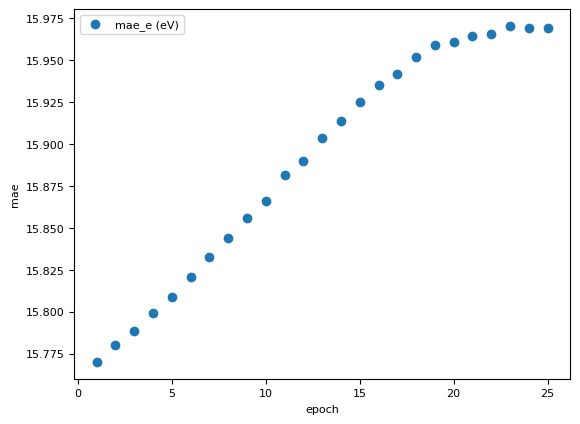

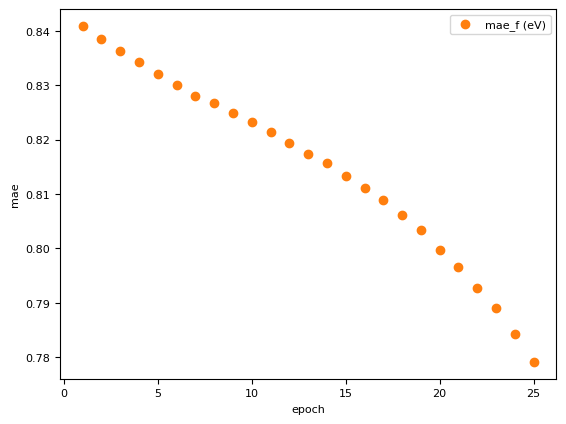

In [8]:
#saving the data in a dataframe to be able to work with it in an easier way
df = pd.DataFrame(data)
#separating the training and validation results
train_df = df[df['mode']=='opt'].copy()
val_df = df[df['mode']=='eval'].copy().dropna()
#train_df = train_df.groupby('epoch', as_index=False)['loss'].last()
train_df = train_df.groupby('epoch', as_index=False)['loss'].mean()
train_df['epoch'] += 1
val_df['epoch'] += 1

#plotting the dataframe
import functions as f
f.plot_mae(val_df, 'epoch', ['mae_e','mae_f'])

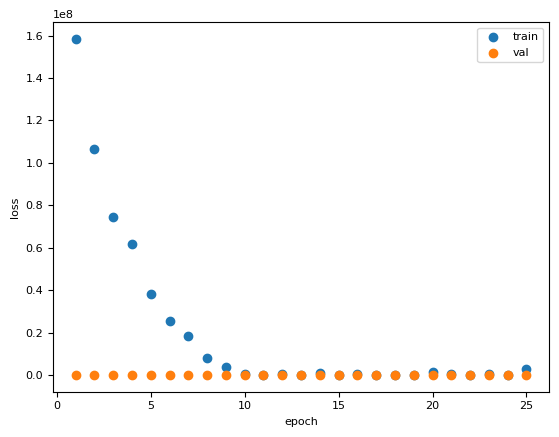

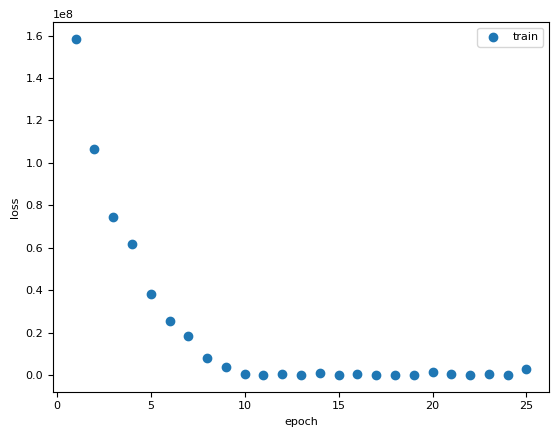

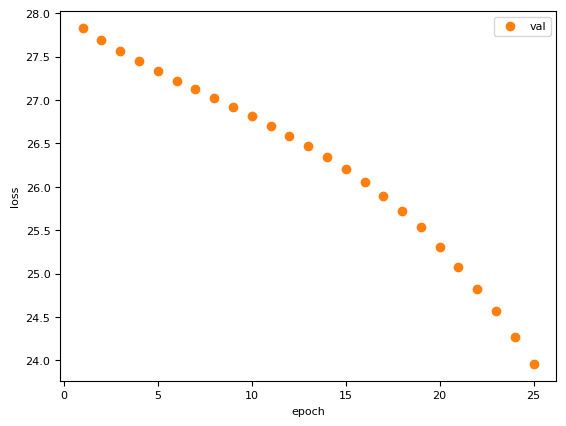

In [9]:
#plotting the validation and loss error
f.plot_loss([(train_df, 'train'),(val_df,'val')],'epoch','loss',model_name)

In [10]:
#the model can be evaluated using this
from mace.cli.eval_configs import main as mace_eval_configs_main
import sys

def eval_mace(model, configs, output, device=device):
    sys.argv=['program', '--configs', configs, '--model', model, '--output', output, '--device', device]
    mace_eval_configs_main()

In [11]:
#evaluating the set on both the training and test datasets
'''eval_mace(model=f'{model_name}.model',
          configs='train_01.xyz',
          output=f'test_res/{model_name}_train.xyz')'''

eval_mace(model=f'{model_name}.model',
          configs='test_01.xyz',
          output=f'test_res/{model_name}_test.xyz')

2025-11-04 21:16:48.279 INFO: Using CPU


In [12]:
from ase.io import read

#importing data from the evaluation of the test set
#read the configurations with the mace predictions
res_list = read(f'test_res/{model_name}_test.xyz', index=':')
#extracting the reference and mace energies
res = [(a.info['REF_energy'], a.info['MACE_energy']) for a in res_list]
df_res = pd.DataFrame(res, columns=['REF_energy', 'MACE_energy'])
df_res

,REF_energy,MACE_energy
0,-107.747095,-93.780153
1,-108.520168,-93.907727
2,-107.695874,-93.759736
3,-106.556392,-93.804976
4,-106.805985,-93.786252
...,...,...
105,-106.479300,-93.599946
106,-102.204540,-93.427476
107,-101.649356,-93.659407
108,-98.841753,-93.520376


In [13]:
#saving to an excel file so that we can keep a register of how different the resuls are for the different models
df_res.to_excel(f'test_res/{model_name}_test.xlsx')

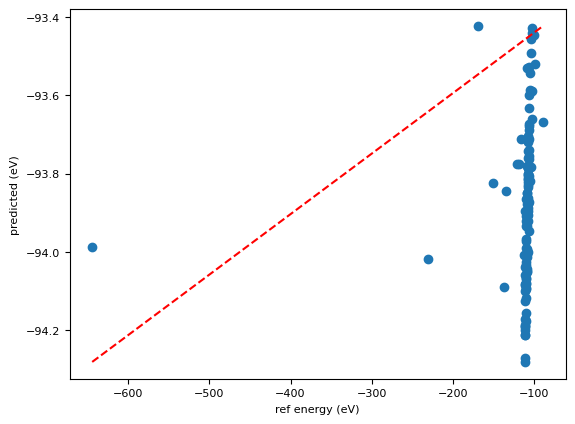

In [14]:
f.plot_energy_comparison(df_res, 'REF_energy', 'MACE_energy')